# Monolithic transient thermo-elasticity
$\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\bj}{\mathbf{j}}$

This demo is a direct transposition of the [transient thermo-elasticity demo](https://comet-fenics.readthedocs.io/en/latest/demo/thermoelasticity/thermoelasticity_transient.html) using a pure `FEniCS` formulation. We will show how to compute fully coupled thermo-mechanical problems using `MFront`, which can pave the way to more complex thermo-mechanical behaviours including plasticity for instance.

## Constitutive equations

The constitutive equations are derived from the following expression of
the Gibbs free energy:

$$
\begin{aligned}
\rho\,\Phi{\left(\beps^{\mathrm{to}},T\right)}&={{\displaystyle \frac{\displaystyle \lambda}{\displaystyle 2}}}\,{\left({\mathrm{tr}{\left(\beps^{\mathrm{to}}\right)}}-3\,\alpha\,{\left(T-T^{\mathrm{ref}}\right)}\right)}^2+
\mu\,{\left(\beps^{\mathrm{to}}-\alpha\,{\left(T-T^{\mathrm{ref}}\right)}\,\mathbf{I}\right)}\,\colon\,{\left(\beps^{\mathrm{to}}-\alpha\,{\left(T-T^{\mathrm{ref}}\right)}\,\mathbf{I}\right)}\\
&+{{\displaystyle \frac{\displaystyle \rho\,C_{\varepsilon}}{\displaystyle 2\,T^{\mathrm{ref}}}}}\,{\left(T-T^{\mathrm{ref}}\right)}^2+s_{0}\,{\left(T-T^{\mathrm{ref}}\right)}
\end{aligned}
$$

where:

-   $\lambda$ and $\mu$ are the Lamé coefficients
-   $\rho$ is the mass density
-   $\alpha$ is mean linear thermal expansion coefficient
-   $C_{\varepsilon}$ is the specific heat at constant strain (per unit
    of mass).

This expression leads to the following expressions of the stress tensor
$\bsig$ and entropy per unit of mass $s$:

$$
\begin{aligned}
\bsig&=\rho \dfrac{\partial \Phi}{\partial \beps^{\mathrm{to}}}=\lambda\,{\mathrm{tr}{\left(\beps^{\mathrm{to}}\right)}}\,\mathbf{I}+2\,\mu\,\beps^{\mathrm{to}}-\kappa\,{\left(T-T^{\mathrm{ref}}\right)}\,\mathbf{I}\\
s&={\displaystyle \frac{\displaystyle \partial \Phi}{\displaystyle \partial T}}={{\displaystyle \frac{\displaystyle C_{\varepsilon}}{\displaystyle T^{\mathrm{ref}}}}}\,{\left(T-T^{\mathrm{ref}}\right)}+{{\displaystyle \frac{\displaystyle \kappa}{\displaystyle \rho}}}\,{\mathrm{tr}{\left(\beps^{\mathrm{to}}\right)}}\\
\end{aligned}
\tag{1}\label{eq:constitutive_equations}$$

where $\kappa=\alpha\,{\left(3\,\lambda+2\,\mu\right)}$.

The heat flux $\bj$ is related to the temperature gradient
$\nabla\, T$ by the linear Fourier law:

$$
\bj=-k\,\nabla\, T
\tag{2}\label{eq:constitutive_equations_2}$$


## `MFront` implementation

### Choice of the domain specific language

The constitutive equations $\eqref{eq:constitutive_equations}$ and  $\eqref{eq:constitutive_equations_2}$ exhibit an explicit expression 
of the thermodynamic forces
${\left(\bsig\, \bj, s\right)}$ as a function of the
gradients
${\left(\beps^{\mathrm{to}}, \nabla T, T\right)}$.

The most suitable domain specific language for this kind of behaviour if
the `DefaultGenericBehaviour`.

``` cxx
@DSL DefaultGenericBehaviour;
```

### Name of the behaviour


The `@Behaviour` keyword allows giving the name of the behaviour:

``` cxx
@Behaviour ThermoElasticity;
```

### Metadata


The following lines add some metadata (authors of the implementation,
date, description):

``` cxx
@Author Thomas Helfer, Jérémy Bleyer;
@Date 19/04/2020;
@Description {
  This simple thermoelastic behaviour allows to perform
  fully coupled thermo-mechanical resolutions.

  See https://comet-fenics.readthedocs.io/ for details.
}
```

### Definition of the gradients and conjugated thermodynamic forces

The gradients are the strain $\beps^{\mathrm{to}}$,
the temperature gradient $\nabla\,T$ and the temperature. The
associated thermodynamic forces are respectively the stress
$\bsig$, the heat flux $\bj$ and the entropy $s$.

$\beps^{\mathrm{to}}$, $\nabla\,T$,
$\bsig$ and $\bj$ are declared as follows:

``` cxx
@Gradient StrainStensor εᵗᵒ;
εᵗᵒ.setGlossaryName("Strain");

@ThermodynamicForce StressStensor σ;
σ.setGlossaryName("Stress");

@Gradient TemperatureGradient ∇T;
∇T.setGlossaryName("TemperatureGradient");

@ThermodynamicForce HeatFlux j;
j.setGlossaryName("HeatFlux");
```

The glossary names are the names seen from the calling solver. Glossary
names are described on [this
page](http://tfel.sourceforge.net/glossary.html).

Due to a `MFront` convention, the temperature is automatically declared
as an external state variable. For this reason, the entropy is declared
as a state variable:

``` cxx
@StateVariable real s;
s.setEntryName("EntropyPerUnitOfMass");
```

In the current version of `MFront`, there is no glossary name associated
with the entropy per unit of mass. In this case, the `setEntryName` is
used to associate a name to this variable.

### Declaration of the tangent operator blocks

By default, all the derivatives of the thermodynamic forces with respect
to the increments of the gradients are declared as tangent operator
blocks, i.e. derivatives that are meant to be used when building the
stiffness matrix at the structural scale.

In this case, this is not appropriate as:

-   some derivatives are known to be null, such as
    ${\displaystyle \frac{\displaystyle \partial \bsig}{\displaystyle \partial \Delta\,\nabla\,T}}$
    and
    ${\displaystyle \frac{\displaystyle \partial \bj}{\displaystyle \partial \Delta\,\beps^{\mathrm{to}}}}$[1].
-   the derivative
    ${\displaystyle \frac{\displaystyle \partial s}{\displaystyle \partial \Delta\,\beps^{\mathrm{to}}}}$
    of the entropy with respect to strain and the derivative
    ${\displaystyle \frac{\displaystyle \partial s}{\displaystyle \partial \Delta\,T}}$
    of the entropy with respect to the temperature are also required.

The required tangent operator blocks are therefore explicitly requested:

``` cxx
@TangentOperatorBlocks{∂σ∕∂Δεᵗᵒ, ∂σ∕∂ΔT, ∂s∕∂ΔT, ∂s∕∂Δεᵗᵒ, ∂j∕∂Δ∇T};
```

### Declaration of the reference temperature

The reference temperature is declared using the `@StaticVariable`
keyword:

``` cxx
@StaticVariable temperature Tʳᵉᶠ = 293.15;
```

Internally `Tʳᵉᶠ` is hold in an immutable static variable.

### Declaration of the material coefficients

The various material coefficients are now declared as parameters:

``` cxx
@Parameter stress E = 70e3;
E.setGlossaryName("YoungModulus");
@Parameter real ν = 0.3;
ν.setGlossaryName("PoissonRatio");
@Parameter massdensity ρ = 2700.;
ρ.setGlossaryName("MassDensity");
@Parameter thermalconductivity α = 2.31e-5 ;
α.setGlossaryName("ThermalExpansion");
@Parameter real Cₑ = 910e-6;
Cₑ.setEntryName("SpecificHeatAtConstantStrainPerUnitOfMass");
@Parameter thermalconductivity k = 237e-6;
k.setGlossaryName("ThermalConductivity");
```

Parameters are global values that can be modified at runtime.

### Computation of the thermodynamic forces and tangent operator blocks


The computation of the thermodynamic forces and tangent operator blocks
is implemented in the `@Integrator` code block:

``` cxx
@Integrator{
```

First, the Lamé coefficients are computed using the built-in
`computeLambda` and `computeMu` functions and then we compute the
$\kappa$ factor:

``` cxx
  const auto λ = computeLambda(E, ν);
  const auto μ = computeMu(E, ν);
  const auto κ = α ⋅ (2 ⋅ μ + 3 ⋅ λ);
```

For brevity, we compute the strain at the end of the time step as
follows:

``` cxx
  const auto ε = εᵗᵒ + Δεᵗᵒ;
```

The computation of the thermodynamic forces is then straightforward and
closely looks like the constitutive equations $\eqref{eq:constitutive_equations}$ and $\eqref{eq:constitutive_equations_2}$:

``` cxx
  σ = λ ⋅ trace(ε) ⋅ I₂ + 2 ⋅ μ ⋅ ε - κ ⋅ (T + ΔT - Tʳᵉᶠ) ⋅ I₂;
  s = Cₑ / Tʳᵉᶠ ⋅ (T + ΔT - Tʳᵉᶠ) + (κ / ρ) ⋅ trace(ε);
  j = -k ⋅ (∇T + Δ∇T);
```

The computation of the consistent tangent operator is only required if
the `computeTangentOperator_` boolean value is true. Again, their
computations is straightforward [2]:

``` cxx
  if (computeTangentOperator_) {
    ∂σ∕∂Δεᵗᵒ = λ ⋅ (I₂ ⊗ I₂) + 2 ⋅ μ ⋅ I₄;
    ∂σ∕∂ΔT = -κ ⋅ I₂;
    ∂s∕∂ΔT = Cₑ / Tʳᵉᶠ;
    ∂s∕∂Δεᵗᵒ = κ ⋅ Cₑ / Tʳᵉᶠ ⋅ I₂;
    ∂j∕∂Δ∇T = -k ⋅ tmatrix<N, N, real>::Id();
  }
```

A final curly bracket then ends the `@Integrator` code block:

``` cxx
}
```

[1] We may also note that those blocks are third order tensors that are
not yet supported by `MFront`.

[2] `N` is the space dimension. `real` is a type alias to the numeric
type used, which depends on the interface used.

## `FEniCS` implementation

### Problem position

The problem consists of a quarter of a square plate perforated by a circular hole. A temperature increase of $\Delta T=+10^{\circ}\text{C}$ will be applied on the hole boundary. Symmetry conditions are applied on the corresponding symmetry planes and stress and flux-free boundary conditions are adopted on the plate outer boundary. Similarly to the [original demo](https://comet-fenics.readthedocs.io/en/latest/demo/thermoelasticity/thermoelasticity_transient.html), we will formulate the problem using the temperature variation as the main unknown.

We first import the relevant modules then define the mesh and some constants.

In [1]:
from dolfin import *
import mgis.fenics as mf
from mshr import Rectangle, Circle, generate_mesh
import numpy as np
import matplotlib.pyplot as plt

L = 1.0
R = 0.1
N = 50  # mesh density

domain = Rectangle(Point(0.0, 0.0), Point(L, L)) - \
    Circle(Point(0.0, 0.0), R, 100)
mesh = generate_mesh(domain, N)

Tref = Constant(293.15)
DThole = Constant(10.0)
dt = Constant(0)  # time step

We now define the relevant FunctionSpace for the considered problem. Since we will adopt a monolithic approach i.e. in which both fields are coupled and solved at the same time, we will need to resort to a Mixed FunctionSpace for both the displacement $\boldsymbol{u}$ and the temperature variation $\Theta = T-T^\text{ref}$.

In [2]:
Vue = VectorElement("CG", mesh.ufl_cell(), 2)  # displacement finite element
Vte = FiniteElement("CG", mesh.ufl_cell(), 1)  # temperature finite element
V = FunctionSpace(mesh, MixedElement([Vue, Vte]))


def inner_boundary(x, on_boundary):
    return near(x[0]**2 + x[1]**2, R**2, 1e-3) and on_boundary


def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary


def left(x, on_boundary):
    return near(x[0], 0) and on_boundary


bcs = [DirichletBC(V.sub(0).sub(1), Constant(0.0), bottom),
       DirichletBC(V.sub(0).sub(0), Constant(0.0), left),
       DirichletBC(V.sub(1), DThole, inner_boundary)]

### Variational formulation and time discretization

The constitutive equations described earlier are completed by the quasi-static equilibrium equation:

$$\begin{equation}
\text{div} \bsig = 0
\end{equation}$$

and the transient heat equation (without source terms):

$$\begin{equation}
\rho T^\text{ref} \dfrac{\partial s}{\partial t} + \text{div} \bj= 0
\end{equation}$$

which can both be written in the following weak form:

$$\begin{align}
\int_{\Omega}\bsig :\nabla^s\widehat{\boldsymbol{u}}\text{ d} \Omega &=\int_{\partial \Omega} (\bsig\cdot\boldsymbol{n})\cdot\widehat{\boldsymbol{u}} dS \quad \forall \widehat{\boldsymbol{u}}\in V_U \\
\int_{\Omega}\rho T^\text{ref} \dfrac{\partial s}{\partial t}\widehat{T}d\Omega - \int_{\Omega} \bj\cdot\nabla \widehat{T}d\Omega &= -\int_{\partial \Omega} \bj\cdot\boldsymbol{n} \widehat{T} dS \quad \forall \widehat{T} \in V_T
\end{align} \tag{3}\label{eq:coupled-system}$$

with $V_U$ and $V_T$ being the displacement and temperature function spaces.

The time derivative in the heat equation is now replaced by an implicit Euler scheme, so that the previous weak form at the time increment $n+1$ is now:

$$\begin{equation}
\int_{\Omega}\rho T^\text{ref} \dfrac{s^{n+1}-s^n}{\Delta t}\widehat{T}d\Omega - \int_{\Omega} \bj^{n+1}\cdot\nabla \widehat{T}d\Omega = -\int_{\partial \Omega} \bj^{n+1}\cdot\boldsymbol{n} \widehat{T} dS \quad \forall \widehat{T} \in V_T
\end{equation}$$

where $s^{n+1},\bj^{n+1}$ correspond to the *unknown* entropy and heat flux at time $t_{n+1}$.

Since both the entropy and the stress tensor depend on the temperature and the total strain, we obtain a fully coupled problem at $t=t_{n+1}$ for $(\boldsymbol{u}_{n+1},T_{n+1})\in V_U\times V_T$. With the retained boundary conditions both right-hand sides in $\eqref{eq:coupled-system}$.

We now load the material behaviour and define the corresponding `MFrontNonlinearProblem`. One notable specificity of the present example is that the unknown field `v` belongs to a mixed function space. Therefore, we cannot rely on automatic registration for the strain and temperature gradient. We will have to specify explicitly their UFL expression with respect to the displacement `u` and temperature variation `Theta` sub-functions of the mixed unknown `v`. We also register the `"Temperature"` external state variable with respect to `Theta`.

In [3]:
material = mf.MFrontNonlinearMaterial("./src/libBehaviour.so",
                                      "ThermoElasticity",
                                      hypothesis="plane_strain")
rho = Constant(material.get_parameter("MassDensity"))
v = Function(V)
(u, Theta) = split(v)
problem = mf.MFrontNonlinearProblem(v, material, quadrature_degree=2, bcs=bcs)
problem.register_gradient("Strain", sym(grad(u)))
problem.register_gradient("TemperatureGradient", grad(Theta))
problem.register_external_state_variable("Temperature", Theta + Tref)

Similarly to the [Transient heat equation with phase change demo](https://thelfer.github.io/mgis/web/mgis_fenics_heat_equation_phase_change.html), we need to specify explicitly the coupled thermo-mechanical residual expression using the stress, heat flux and entropy variables. For the implicit Euler scheme, we will need to define the entropy at the previous time step. For the mechanical residual, note that the stress variable `sig` is represented in the form of its vector of components. The computation of $\bsig :\nabla^s\widehat{\boldsymbol{u}}$ therefore requires to express $\widehat{\beps}=\nabla^s\widehat{\boldsymbol{u}}$ in the same way. For this purpose, we could use the `mgis.fenics.utils.symmetric_tensor_to_vector` on the tensorial UFL expression `sym(grad(u))`. Another possibility is to get the corresponding `"Strain"` gradient object (expressed in vectorial form) and get his variation with respect to `v_`. 

In [4]:
sig = problem.get_flux("Stress")
j = problem.get_flux("HeatFlux")
s = problem.get_state_variable("EntropyPerUnitOfMass")
problem.initialize()

s_old = s.copy(deepcopy=True)
v_ = TestFunction(V)
u_, T_ = split(v_)  # Displacement and temperature test functions
eps_ = problem.gradients["Strain"].variation(v_)
mech_residual = dot(sig, eps_)*problem.dx
thermal_residual = (rho*Tref*(s - s_old)/dt*T_ - dot(j, grad(T_)))*problem.dx
problem.residual = mech_residual + thermal_residual
problem.compute_tangent_form()

## Resolution

The problem is now solved by looping over time increments. Because of the typical exponential time variation of temperature evolution of the heat equation, time steps are discretized on a non-uniform (logarithmic) scale. $\Delta t$ is therefore updated at each time step. The previous entropy field `s_old` is updated at the end of each step.

In [5]:
Nincr = 10
t = np.logspace(1, 4, Nincr + 1)
Nx = 100
x = np.linspace(R, L, Nx)
T_res = np.zeros((Nx, Nincr + 1))
for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i + 1))
    dt.assign(dti)
    problem.solve(v.vector())

    s_old.assign(s)

    T_res[:, i + 1] = [v(xi, 0.0)[2] for xi in x]

Increment 1
Increment 2
Increment 3
Increment 4
Increment 5
Increment 6
Increment 7
Increment 8
Increment 9
Increment 10


At each time increment, the variation of the temperature increase $\Delta T$ along a line $(x, y=0)$ is saved in the `T_res` array. This evolution is plotted below. As expected, the temperature gradually increases over time, reaching eventually a uniform value of $+10^{\circ}\text{C}$ over infinitely long waiting time. We check that we obtain the same solution as the pure `FEniCS` demo.

<IPython.core.display.Javascript object>


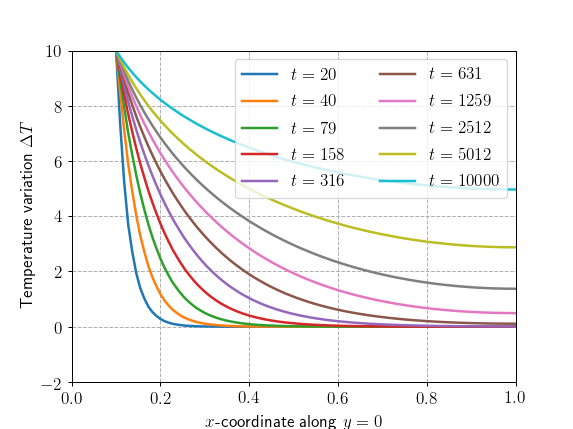

In [7]:
%matplotlib notebook

plt.figure()
plt.plot(x, T_res[:, 1::Nincr // 10])
plt.xlabel("$x$-coordinate along $y=0$")
plt.ylabel("Temperature variation $\Delta T$")
plt.legend(["$t={:.0f}$".format(ti) for ti in t[1::Nincr // 10]], ncol=2)
plt.show()